# College Football Prediction Model

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

In [3]:
# all data has been pulled from collegefootballdata.com

# read in team list and extract only school, color, and conference
# Note: Only FBS teams matter aka these 131 teams
# we do not care about FCS data due to the massive gap 
# in talent between these divisions
df = pd.read_csv("TEAMS.csv")
df_teams = df[["id", "school", "conference", "color"]]
df_teams.sort_values(by=["school"], inplace=True)
print(df_teams)

       id             school      conference    color
0    2005          Air Force   Mountain West  #004a7b
1    2006              Akron    Mid-American  #00285e
2     333            Alabama             SEC  #690014
3    2026  Appalachian State        Sun Belt  #000000
4      12            Arizona          Pac-12  #002449
..    ...                ...             ...      ...
128   277      West Virginia          Big 12  #FFC600
126    98   Western Kentucky  Conference USA  #F32026
127  2711   Western Michigan    Mid-American  #532e1f
129   275          Wisconsin         Big Ten  #A00001
130  2751            Wyoming   Mountain West  #533B22

[131 rows x 4 columns]


In [4]:
# read in coach data
# extract school of coach and their rating from the "simple rating system"
df = pd.read_csv("COACH_RECORD.csv")
df_coach = df[["school", "srs"]]
# dropping this row bc they had Univ. of South FL in here twice
df_coach = df_coach.drop(df.index[110])
df_coach.sort_values(by=["school"], inplace=True)
print(df_coach)

                school   srs
17           Air Force   2.3
94               Akron -14.2
106            Alabama  19.6
24   Appalachian State  -0.6
46             Arizona  -1.7
..                 ...   ...
16       West Virginia   5.0
64    Western Kentucky  -1.8
81    Western Michigan -13.9
22           Wisconsin   4.6
10             Wyoming -10.7

[131 rows x 2 columns]


In [5]:
# read in team talent composite data
# these are ratings on each teams based on
# an average of different recruiting sights
df_talent = pd.read_csv("TEAM_TALENT_COMP.csv")
df_talent = df_talent[["school", "talent"]]
df_talent.sort_values(by=["school"], inplace=True)

# remove all FCS/lower division teams
print("FCS teams removed:")
fcs = list(set(df_teams['school']).symmetric_difference(set(df_talent['school'])))
print(fcs)

filter = df_talent["school"].isin(df_teams["school"])
df_talent = df_talent[filter]
print()
print("Filtered Team Talent Data")

print(df_talent)


FCS teams removed:
['Southern', 'Mercer', 'Portland State', 'Bryant', 'Samford', 'Mississippi Valley State', 'Duquesne', 'Montana State', 'North Carolina Central', 'Western Carolina', 'Southeastern Louisiana', 'Towson', 'Monmouth', 'Tennessee Tech', 'Villanova', 'Arkansas-Pine Bluff', 'Murray State', 'Missouri State', 'Campbell', 'South Dakota', 'Florida A&M', 'North Carolina A&T', 'Eastern Washington', 'Eastern Kentucky', 'Southern Utah', 'Northern Arizona', 'Idaho', 'Colgate', 'Central Arkansas', 'North Dakota State', 'Lamar', 'Northwestern State', 'Prairie View', 'Albany', 'Cal Poly', 'Kennesaw State', 'The Citadel', 'Alabama A&M', 'New Hampshire', 'William & Mary', 'San Diego', 'Alcorn State', 'Bethune-Cookman', 'Lafayette', 'Yale', 'Alabama State', 'Richmond', 'Jackson State', 'Austin Peay', 'Youngstown State', 'Morgan State', 'Valparaiso', 'Stony Brook', 'Elon', 'North Alabama', 'Eastern Illinois', 'Montana', 'Wofford', 'Furman', 'Southern Illinois', 'Texas Southern', 'South Caro

In [6]:
# now we can combine the previous three datasets into one
# that consists of school, conference, coach rating, and talent rating
d1 = pd.merge(df_teams, df_coach, on ='school')
team_data = pd.merge(d1, df_talent, on ='school')
print(team_data)

       id             school      conference    color   srs   talent
0    2005          Air Force   Mountain West  #004a7b   2.3     0.00
1    2006              Akron    Mid-American  #00285e -14.2   456.15
2     333            Alabama             SEC  #690014  19.6  1016.79
3    2026  Appalachian State        Sun Belt  #000000  -0.6   456.66
4      12            Arizona          Pac-12  #002449  -1.7   652.06
..    ...                ...             ...      ...   ...      ...
126   277      West Virginia          Big 12  #FFC600   5.0   662.57
127    98   Western Kentucky  Conference USA  #F32026  -1.8   495.64
128  2711   Western Michigan    Mid-American  #532e1f -13.9   449.89
129   275          Wisconsin         Big Ten  #A00001   4.6   744.44
130  2751            Wyoming   Mountain West  #533B22 -10.7   292.03

[131 rows x 6 columns]


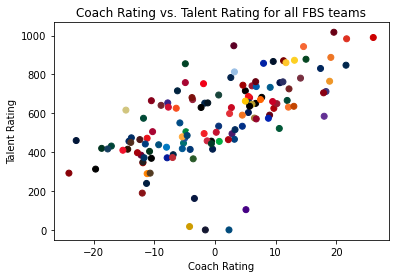

In [7]:
# scatter plot that represents teams based on
# talent and coaching acumen

plt.scatter(team_data["srs"], team_data["talent"], c = team_data["color"])
plt.xlabel("Coach Rating")
plt.ylabel("Talent Rating")
plt.title("Coach Rating vs. Talent Rating for all FBS teams")
plt.show()

In [8]:
# read in final results from 2022 regular season
# remove all FCS data, including FBS vs. FCS matchups
# remove games that have not happened yet
# remove irrelevant columns 
df_results = pd.read_csv("FINAL_RESULTS.csv")
df_spreads = pd.read_csv("spreads.csv")
df_spreads = df_spreads.loc[(df_spreads["lineProvider"] == "consensus")]
df_s = df_spreads[["id", "spread"]]
r2d2 = pd.merge(df_results, df_s, on ="id")
df_results = r2d2
#r2d2 = pd.merge(df_results, df_spreads, on ='school')
#team_data = pd.merge(d1, df_talent, on ='school')
#print(team_data)


df_results = df_results.loc[(df_results["completed"] == True) & (df_results["home_division"] == "fbs") & (df_results["away_division"] == "fbs")]
df_results.drop(['id', 'excitement_index', 'home_team', 'away_team', 'away_post_win_prob', 'away_pregame_elo', 'away_postgame_elo', 'away_conference','home_postgame_elo', 'home_post_win_prob', 'home_pregame_elo', 'away_division','home_conference', 'home_division', 'season', 'season_type', 'conference_game', 'start_date', 'attendance', 'venue_id', 'venue', 'highlights', 'notes', 'start_time_tbd', 'completed'], axis=1, inplace=True)
df_results["margin"] = df_results["home_points"] - df_results["away_points"]
df_results.drop(['home_line_scores[0]', 'home_line_scores[1]', 'home_line_scores[2]', 'home_line_scores[3]'], axis=1, inplace=True)
df_results.drop(['away_line_scores[0]', 'away_line_scores[1]', 'away_line_scores[2]', 'away_line_scores[3]'], axis=1, inplace=True)
df_results = df_results.dropna()

# add talent and coach rating for the home and away teams
home_tal = []
away_tal = []
home_c = []
away_c = []

i = 0
for index, row in df_results.iterrows():
    i = row['home_id']
    team = team_data.loc[team_data["id"] == i]
    t = float(team["talent"])
    c = float(team["srs"])
    home_tal.append(t)
    home_c.append(c)
    i = row['away_id']
    team = team_data.loc[team_data["id"] == i]
    t = float(team["talent"])
    c = float(team["srs"])
    away_tal.append(t)
    away_c.append(c)

    
df_results["home_talent"] = home_tal
df_results["away_talent"] = away_tal
df_results["home_coach"] = home_c
df_results["away_coach"] = away_c

print(df_results)

      week  neutral_site  home_id  home_points  away_id  away_points  spread  \
1        1          True       77         31.0      158         28.0    12.5   
4        1         False      328         31.0       41         20.0   -24.0   
5        1         False      356         38.0     2751          6.0   -14.0   
10       1         False     2638         13.0      249         31.0     1.5   
11       1         False      166         12.0     2440         23.0     7.0   
...    ...           ...      ...          ...      ...          ...     ...   
1195    14          True       61         50.0       99         30.0   -17.5   
1196    14         False       68         16.0      278         28.0    -3.0   
1197    14         False     2655         45.0     2116         28.0    -3.5   
1198    14          True      153         10.0      228         39.0     7.5   
1199    14          True      130         43.0     2509         22.0   -16.0   

      margin  home_talent  away_talent 

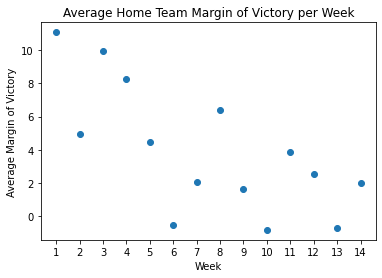

In [9]:
# Scatterplot of average home team margin of victory week-to-week
m = [] # average margin of victory for home team
w = [1,2,3,4,5,6,7,8,9,10,11,12,13,14] # weeks

for n in range(1,15):
    d = df_results.loc[df_results["week"] == n]
    total = d["margin"]
    m.append(np.average(total))
    
plt.scatter(w, m)
plt.title("Average Home Team Margin of Victory per Week")
plt.xlabel("Week")
plt.xticks(w)
plt.ylabel("Average Margin of Victory")
plt.show()

# as you can see, the away team has handled playing on the road
# better on average per week

In [10]:
# lets set up our neural network

df_r = df_results[["week", "neutral_site", "spread", "home_talent", "away_talent", "home_coach", "away_coach"]]
df_y = df_results[["margin"]]
y = df_y.to_numpy()
X = df_r.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.07, random_state=42)

# standardize data? 
object = StandardScaler()
X_train_1 = object.fit_transform(X_train)
X_test_1 = object.fit_transform(X_test)
X_train = X_train_1
X_test = X_test_1

splits = KFold(n_splits=3)
neuron_arr = [50, 100, 200, 500]
learn_arr = [.0001, .001, .01, .1, 1]
acc_arr = []

# find accuracies for each combination
# using K-fold cross-validation
for n in neuron_arr:
    for l in learn_arr:
        scores = []
        for train_index, val_index in splits.split(X_train):
            clf = MLPClassifier(hidden_layer_sizes=(n),
                    random_state=42,
                    verbose=False,
                    activation="tanh",
                    solver="sgd",
                    learning_rate_init=l)

            X_subtrain = X_train[train_index]
            X_val = X_train[val_index]
            y_subtrain = y_train[train_index]
            y_val = y_train[val_index]
            clf.fit(X_subtrain, y_subtrain)
            y_predict = clf.predict(X_val)
            scores.append(accuracy_score(y_val, y_predict))

            
        print("N=" + str(n))
        print("L=" + str(l))
        print("score=" + str(np.mean(scores)) + "\n")
        acc_arr.append(np.mean(scores))

N=50
L=0.0001
score=0.011918108050395046

N=50
L=0.001
score=0.05814915652359598

N=50
L=0.01
score=0.05366485159086056

N=50
L=0.1
score=0.03425955584027333

N=50
L=1
score=0.038770553064275036

N=100
L=0.0001
score=0.022341447789878285

N=100
L=0.001
score=0.056641042067051034

N=100
L=0.01
score=0.05813581037796284

N=100
L=0.1
score=0.0253309844117019

N=100
L=1
score=0.026845771941063423

N=200
L=0.0001
score=0.020873371770232758

N=200
L=0.001
score=0.058129137305146274

N=200
L=0.01
score=0.05963057868887465

N=200
L=0.1
score=0.023849562246423234

N=200
L=1
score=0.017870489002775998

N=500
L=0.0001
score=0.017890508221225707

N=500
L=0.001
score=0.06113869314541961

N=500
L=0.01
score=0.06259342301943199

N=500
L=0.1
score=0.029801943198804182

N=500
L=1
score=0.03427957505872304



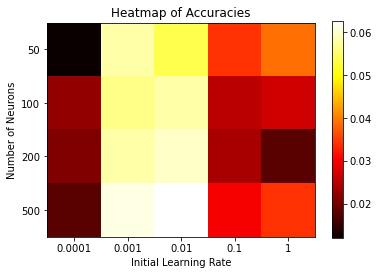

In [11]:
# Heatmap time
accuracy_arr = np.array(acc_arr)
acc_2D = accuracy_arr.reshape(4,5)

y_labels = ["50", "100", "200", "500"]
x_labels = ["0.0001", "0.001", "0.01", "0.1", "1"]

plt.imshow(acc_2D, cmap='hot', interpolation='nearest')
plt.title('Heatmap of Accuracies')
plt.xticks(range(0,len(x_labels)), x_labels)
plt.yticks(range(0,len(y_labels)), y_labels)
plt.colorbar()
plt.xlabel("Initial Learning Rate")
plt.ylabel("Number of Neurons")
plt.show()

# 500 neurons
# .01 Learning rate is the best

In [12]:
combos = [(500,200,100), (500,100), (1000,500,50), (500,50)]

for c in combos:
    scores = []
    for train_index, val_index in splits.split(X_train):
        clf = MLPClassifier(hidden_layer_sizes=(c),
            random_state=42,
            verbose=False,
            activation="tanh",
            solver="sgd",
            learning_rate_init=0.01)

        X_subtrain = X_train[train_index]
        X_val = X_train[val_index]
        y_subtrain = y_train[train_index]
        y_val = y_train[val_index]
        clf.fit(X_subtrain, y_subtrain)
        y_predict = clf.predict(X_val)
        scores.append(accuracy_score(y_val, y_predict))
    
    print("Combination: ", end = "")
    print(c)
    print("score=" + str(np.mean(scores)) + "\n")
    
# combo 100-100-20 works the best, but also this is due to overfitting.
# It started predicting every outcome as a field goal win. This is because the most common score 
# differential is a field goal
# notice how the accuracies are so low. this is due to the fact
# that it is not projecting a winner, it is projecting the margin of
# victory or defeat for the home team. 

Combination: (500, 200, 100)
score=0.04023862908392056

Combination: (500, 100)
score=0.04919389280375828

Combination: (1000, 500, 50)
score=0.04470291479820628

Combination: (500, 50)
score=0.05666106128550075



In [13]:
# The model
clf = MLPClassifier(hidden_layer_sizes=((1000,100)),
            random_state=42,
            verbose=False,
            activation="tanh",
            solver="sgd",
            learning_rate_init=.001)

# fit the model
clf.fit(X, y)

MLPClassifier(activation='tanh', hidden_layer_sizes=(1000, 100),
              random_state=42, solver='sgd')

In [15]:
# Team = ID
print(team_data.loc[team_data["school"] == "Toledo"])
print(team_data.loc[team_data["school"] == "Liberty"])

# create matchups to test with 
# format: ["week", "neutral_site", "spread", "home_id", "away_id", "home_talent", "away_talent", "home_coach", "away_coach"]

# Predicting the New Year's Six Bowl Games
print("New Year's Six Bowl Games")

# Peach Bowl
peach = [[15, False, -6.5, 989.76, 983.14, 26.1, 21.7]]
score_predict1 = clf.predict(peach)
print("Peach Bowl:  Georgia(", end = '')
print(int(score_predict1)*-1, end ='')
print(") vs. Ohio State")

# Fiesta Bowl
fiesta = [[15, True, -7.5, 847.24, 712.05, 21.6, 18.3]]
score_predict2 = clf.predict(fiesta)
print("Fiesta Bowl:  Michigan(", end = '')
print(int(score_predict2)*-1, end ='')
print(") vs. TCU")

# Orange Bowl
orange = [[15, True, 6.5, 764.8, 943.0, 18.9, 14.6]]
score_predict3 = clf.predict(orange)
print("Orange Bowl: Tennessee", end = '(')
print(int(score_predict3)*-1, end ='')
print(") vs. Clemson")

# Rose Bowl
rose = [[15, True, 2.5, 830.44, 705.12, 17.4, 17.9]]
score_predict4 = clf.predict(rose)
print("Rose Bowl:  Penn State(", end = '')
print(int(score_predict4)*-1, end ='')
print(") vs. Utah")
# Sugar Bowl
sugar = [[15, True, -3.5, 1016.79, 584.68, 19.6, 18.0]]
score_predict5 = clf.predict(sugar)
print("Sugar Bowl: Alabama(", end = '')
print(int(score_predict5)*-1, end ='')
print(") vs. Kansas State")

# Cotton Bowl
cotton = [[15, True, -1.5, 860.12, 521.86, 11.7, 10.6]]
score_predict6 = clf.predict(cotton)
print("Cotton Bowl:  USC(", end = '')
print(int(score_predict6)*-1, end ='')
print(") vs. Tulane",)
print()

# National Championship Game
matchup = [[15, True, -8.5, 989.76, 847.24, 26.1, 21.6]]
score_predict7 = clf.predict(matchup)
print("National Title Game:", end = " ")
print("Georgia(", end = ' ')
print(int(score_predict7)*-1, end ='')
print(") vs. Michigan", end = '')
print("\n\n")

# Boca Raton Bowl
matchup = [[15, True, -3.5, 498.98, 161.88, -3.9, -3.4]]
score_predict7 = clf.predict(matchup)
print("Boca Raton Bowl:", end = " ")
print("Toledo(", end = ' ')
print(int(score_predict7)*-1, end ='')
print(") vs. Liberty", end = '')





       id  school    conference    color  srs  talent
106  2649  Toledo  Mid-American  #ffffff -3.9  498.98
      id   school        conference    color  srs  talent
50  2335  Liberty  FBS Independents  #071740 -3.4  161.88
New Year's Six Bowl Games
Peach Bowl:  Georgia(-3) vs. Ohio State
Fiesta Bowl:  Michigan(-3) vs. TCU
Orange Bowl: Tennessee(7) vs. Clemson
Rose Bowl:  Penn State(-3) vs. Utah
Sugar Bowl: Alabama(-28) vs. Kansas State
Cotton Bowl:  USC(-28) vs. Tulane

National Title Game: Georgia( -3) vs. Michigan



Boca Raton Bowl: Toledo( -31) vs. Liberty